## Orientation from 3 markers

### Example of a marked bee
Bumblebees are eusocial insects. The bees of the specie *bombus terrestris* have their hive underground, and can access it by a hole. When leaving the hive, they perform a learning and orientation flight to remember the location of the hive entrance and decide in which direction they should forage or explore the environment. Bees can be filmed while perforing their learning flight. As we have seen before, 3 points or markers need to be placed on the bee's thorax to determine its orientation. Bees have therefore been marked with three points, forming a triangle, on their thorax

.. image:: media/marked_bumblebee.png

**Note** The dataset used in this example come from recording made at the University of Bielefeld in Martin Egelhaaf's group, by Charlotte Doussot. 

### Position of the thorax's markers along time


**Note** due to occlusion during the experiment, at several time-points, the positions of the markers have not been recorded.



/home/bolirev/.virtualenvs/toolbox-navigation/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/bolirev/.virtualenvs/toolbox-navigation/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


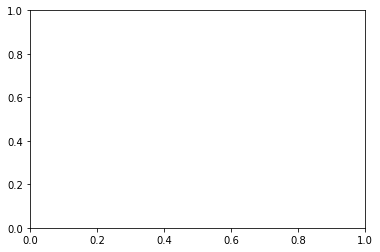

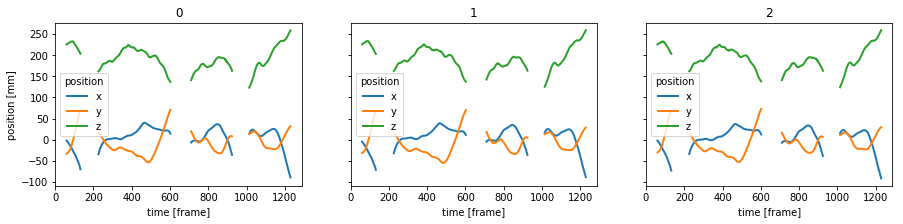

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pkg_resources
%matplotlib inline

bumblebee_flight = pkg_resources.resource_filename(
    'navipy', 'resources/sample_experiment/Doussot_2017/bee007.hdf')
markers = pd.read_hdf(bumblebee_flight, 'markers')
markers_thorax = [0, 1, 2]

fig, axarr = plt.subplots(1, len(markers_thorax),
                          figsize=(15, 3),
                          sharey=True)
for plt_i, cmark_name in enumerate(markers_thorax):
    markers.loc[:, cmark_name].plot(ax=axarr[plt_i],
                                    linewidth=2)
    axarr[plt_i].set_title(cmark_name)
    axarr[plt_i].set_xlabel('time [frame]')
    axarr[plt_i].set_ylabel('position [mm]')

### Yaw, pitch and roll along time

We use the markers from above. To calculate the orientation, the euler axis convention as well as how our 
markers are placed relative to the three rotational axis of the thorax.

In [2]:
rotconv = 'zyx'
triangle_mode = 'y-axis=2-1'

We can use get yaw-pitch-roll from markers by building the trajectory out of the markers

In [3]:
from navipy.trajectories import Trajectory

In [4]:
mytrajectory = Trajectory(rotconv=rotconv).from_markers(markers, triangle_mode, markers_labels=markers_thorax)

The angles are in radians. Some persons prefer to read angle in degrees

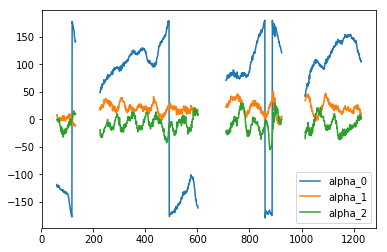

In [5]:
np.rad2deg(mytrajectory.loc[:, rotconv].astype(float)).plot()

In our case:
* alpha_0 is the rotation around the z" axis
* alpha_1 is the rotation around the y' axis
* alpha_2 is the rotation around the x axis

### Filtering 
#### Low pass

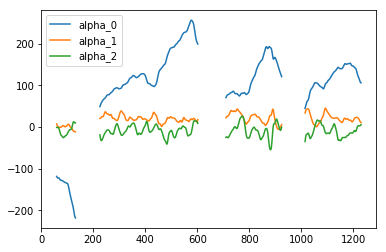

In [8]:
mytraj = Trajectory().from_dataframe(mytrajectory)
mytraj.sampling_rate = 500
mytraj.filtfilt(order=8, cutoff = 50)
np.rad2deg(mytraj.loc[:, rotconv].astype(float)).plot()

#### Cspline

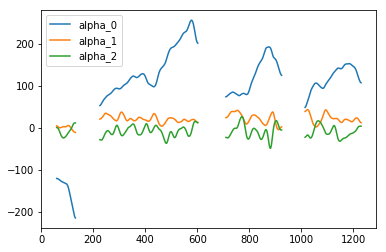

In [9]:
mytraj = Trajectory().from_dataframe(mytrajectory)
lamb = pd.Series(index= mytraj.columns, data=150)
mytraj.filt_cspline(lamb=lamb)
np.rad2deg(mytraj.loc[:, rotconv].astype(float)).plot()

### Angluar velocity

(see https://www.astro.rug.nl/software/kapteyn-beta/_downloads/attitude.pdf)

The angular velocity can be derived from euler angle rates

In [11]:
angvel=dict()
for frame in ['global', 'body']:
    angvel[frame] = mytraj.velocity(frame = frame)
    angvel[frame] = np.rad2deg(angvel[frame])

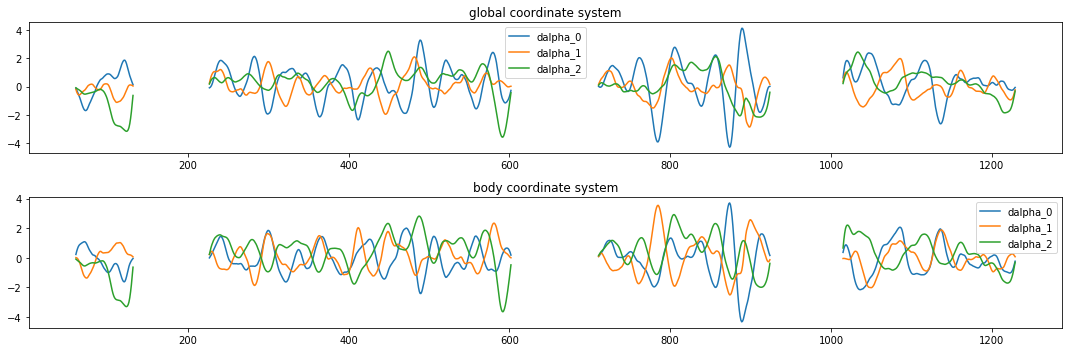

In [12]:
fig, axarr = plt.subplots(2,1, figsize=(15,5))
for axi, frame in enumerate(['global', 'body']):
    angvel[frame].loc[:,mytrajectory.rotation_mode].plot(ax=axarr[axi])
    axarr[axi].set_title('{} coordinate system'.format(frame))
plt.tight_layout()

In [28]:
angspeed = {key:np.sqrt((av**2).sum(axis=1)) for key, av in angvel.items()}

In [29]:
np.allclose(angspeed['global'],angspeed['body'])

True

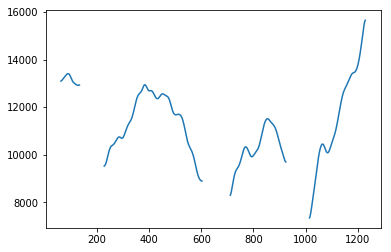

In [30]:
angspeed = angspeed['global'].copy()
angspeed.loc[angvel[frame].isna().any(axis=1)]=np.nan
angspeed.plot()